# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [2]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


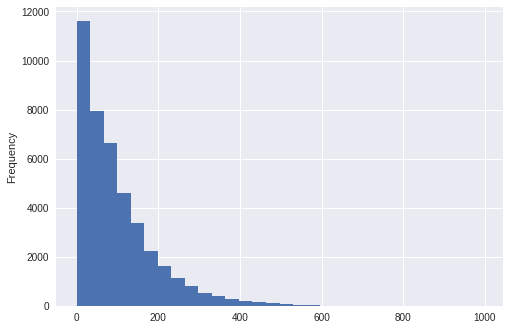

In [6]:
#y variable pm2.5
df['pm2.5'].plot.hist(bins=30);
#right skew
#mean > median
#Application: loans
#we want to be conservative of how much 
#if we fit to mean we give too much loans
#a quantile model would allow them to choose
#find 'median user'
#Application: health predictions based on birth weigh
#in

In [5]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y) #not well #25% r squared

0.2590006399659215

In [7]:
','.join(['1','2','3']) 
#this is how csv files are made and how we'll construct the quant formula

'1,2,3'

In [8]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'}) #statsmodels doesn't like periods

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        17:45:24   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
#coef - median (or q) effect of x on y
#t = coef/std error
0.8830 / 0.031
#psuedo rsquared

28.483870967741936

In [0]:
#How to pick quantiles

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [10]:
quantiles = (.05, .96, .1)
#How to pick quantiles
#what is most appropiate for your needs?
#more important to underpredict - closer to median
#more important to overpredict - closer to one
#tests for each quantile
for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())
#r2 between qs isn't comparable because of skew

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        17:53:10   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [11]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)


KeyboardInterrupt: ignored

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2614
Model:                       QuantReg   Bandwidth:                     0.01908
Method:                 Least Squares   Sparsity:                       0.6060
Date:                Mon, 21 Jan 2019   No. Observations:                41757
Time:                        00:41:40   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.016e-06   6.52e-08     15.579      0.000    8.88e-07    1.14e-06
No         -7.472e-07   1.01e-07     -7.406      0.000   -9.45e-07   -5.49e-07
year           0.0027      0.000     21.867      0.000       0.002       0.003
month         -0.0075      0.000    -19.825      0.000      -0.008      -0.007
day            0.0014      0.000      9.770      0.000       0.001       0.002
hour           0.0049      0.000     23.971      0.000       0.004       0.005
DEWP           0.0155      0.000     89.454      0.000       0.015       0.016
TEMP          -0.0172      0.000    -77.079      0.000      -0.018      -0.017
PRES          -0.0036      0.000    -14.870      0.000      -0.004      -0.003
Iws           -0.0010   2.42e-05    -39.707      0.000      -0.001      -0.001
Is            -0.0025      0.002     -1.517      0.129      -0.006       0.001
Ir            -0.0235      0.001    -29.010      0.000      -0.025      -0.022
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [12]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

#predict actions per minute for StarCraft players
#first check swew to understand the most useful quantiles
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
GameID                  3395 non-null int64
LeagueIndex             3395 non-null int64
Age                     3395 non-null object
HoursPerWeek            3395 non-null object
TotalHours              3395 non-null object
APM                     3395 non-null float64
SelectByHotkeys         3395 non-null float64
AssignToHotkeys         3395 non-null float64
UniqueHotkeys           3395 non-null int64
MinimapAttacks          3395 non-null float64
MinimapRightClicks      3395 non-null float64
NumberOfPACs            3395 non-null float64
GapBetweenPACs          3395 non-null float64
ActionLatency           3395 non-null float64
ActionsInPAC            3395 non-null float64
TotalMapExplored        3395 non-null int64
WorkersMade             3395 non-null float64
UniqueUnitsMade         3395 non-null int64
ComplexUnitsMade        3395 non-null float64
ComplexAbilitiesUsed    3395 non

In [14]:
df.isnull().sum() #miscoded as str

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [0]:
hasNaN = ['Age', 'HoursPerWeek', 'TotalHours']
for feature in hasNaN:
  df[feature] = pd.to_numeric(df[feature], errors='coerce')

In [0]:
df = df.dropna()

In [21]:
df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

y = df['APM']
X = df.drop('APM', axis='columns')

model.fit(X,y)

model.score(X,y) #oh its actually good

0.9727919594327304

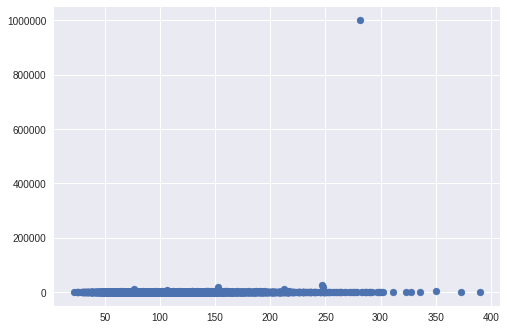

In [23]:
#are there outliers?
import matplotlib.pyplot as plt

plt.scatter(df['APM'], df['TotalHours'])
plt.show() #a million hours?

In [0]:
df = df[(df['TotalHours'] < 5000)]

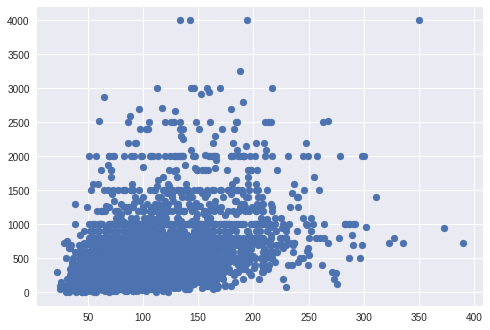

In [27]:
plt.scatter(df['APM'], df['TotalHours'])
plt.show()

In [28]:
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)
print(quant_formula)

APM ~ GameID + LeagueIndex + Age + HoursPerWeek + TotalHours + SelectByHotkeys + AssignToHotkeys + UniqueHotkeys + MinimapAttacks + MinimapRightClicks + NumberOfPACs + GapBetweenPACs + ActionLatency + ActionsInPAC + TotalMapExplored + WorkersMade + UniqueUnitsMade + ComplexUnitsMade + ComplexAbilitiesUsed


In [29]:
#let's look at the top 10% of players - 0.9
import statsmodels.formula.api as smf

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary() 

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.8923
Model:                       QuantReg   Bandwidth:                       1.353
Method:                 Least Squares   Sparsity:                        28.91
Date:                Wed, 27 Feb 2019   No. Observations:                 3325
Time:                        18:46:10   Df Residuals:                     3305
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -107.8652      3.044    -35.437      0.000    -113.833    -101.897
GameID                2.087e-05   5.66e-05      0.369      0.712      -9e-05       0.000
LeagueIndex             -0.4397      0.154     -2.848      0.004      -0.742      -0.137
Age                      0.0666      0.042      1.581      0.114      -0.016       0.149
HoursPerWeek             0.0351      0.015      2.283      0.023       0.005       0.065
TotalHours              -0.0002      0.000     -0.434      0.664      -0.001       0.001
SelectByHotkeys       5408.7599     39.088    138.373      0.000    5332.120    5485.399
AssignToHotkeys       -326.7892   1037.899     -0.315      0.753   -2361.780    1708.201
UniqueHotkeys            0.0126      0.069      0.183      0.855      -0.122       0.147
MinimapAttacks        2417.9964   1046.642      2.310      0.021     365.865    4470.128
MinimapRightClicks    2562.2417    490.175      5.227      0.000    1601.165    3523.318
NumberOfPACs           3.14e+04    399.744     78.538      0.000    3.06e+04    3.22e+04
GapBetweenPACs           0.0911      0.014      6.311      0.000       0.063       0.119
ActionLatency            0.1028      0.021      4.860      0.000       0.061       0.144
ActionsInPAC            17.6057      0.153    114.909      0.000      17.305      17.906
TotalMapExplored        -0.1022      0.030     -3.433      0.001      -0.161      -0.044
WorkersMade            868.3935    331.954      2.616      0.009     217.537    1519.250
UniqueUnitsMade         -0.3024      0.105     -2.880      0.004      -0.508      -0.097
ComplexUnitsMade     -1976.4192    156.573    -12.623      0.000   -2283.409   -1669.429
ComplexAbilitiesUsed -4253.0208    629.360     -6.758      0.000   -5486.995   -3019.046
========================================================================================

The condition number is large, 6.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
#top half is less glitchy
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()y76

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.8617
Model:                       QuantReg   Bandwidth:                       1.566
Method:                 Least Squares   Sparsity:                        11.22
Date:                Wed, 27 Feb 2019   No. Observations:                 3325
Time:                        18:52:44   Df Residuals:                     3305
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -65.9056      1.814    -36.333      0.000     -69.462     -62.349
GameID                3.796e-05   3.72e-05      1.020      0.308    -3.5e-05       0.000
LeagueIndex             -0.2254      0.102     -2.202      0.028      -0.426      -0.025
Age                     -0.0395      0.025     -1.603      0.109      -0.088       0.009
HoursPerWeek            -0.0060      0.009     -0.645      0.519      -0.024       0.012
TotalHours               0.0008      0.000      3.383      0.001       0.000       0.001
SelectByHotkeys       5409.7086     25.095    215.568      0.000    5360.505    5458.912
AssignToHotkeys      -3095.6395    593.299     -5.218      0.000   -4258.909   -1932.370
UniqueHotkeys            0.2001      0.048      4.182      0.000       0.106       0.294
MinimapAttacks       -1930.7857    667.523     -2.892      0.004   -3239.586    -621.985
MinimapRightClicks    3042.0534    303.333     10.029      0.000    2447.313    3636.794
NumberOfPACs          2.546e+04    240.248    105.972      0.000     2.5e+04    2.59e+04
GapBetweenPACs           0.0177      0.009      2.063      0.039       0.001       0.035
ActionLatency           -0.0834      0.012     -7.067      0.000      -0.107      -0.060
ActionsInPAC            14.9220      0.096    156.031      0.000      14.735      15.110
TotalMapExplored        -0.0332      0.018     -1.867      0.062      -0.068       0.002
WorkersMade            823.9202    210.634      3.912      0.000     410.933    1236.907
UniqueUnitsMade         -0.2954      0.066     -4.444      0.000      -0.426      -0.165
ComplexUnitsMade        97.7796     93.438      1.046      0.295     -85.423     280.982
ComplexAbilitiesUsed   158.2475    372.675      0.425      0.671    -572.449     888.944
========================================================================================

The condition number is large, 6.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates.** First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces** - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [62]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [22]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [23]:
bwt_df.info() #all are numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 7 columns):
bwt          1174 non-null int64
gestation    1174 non-null int64
parity       1174 non-null int64
age          1174 non-null int64
height       1174 non-null int64
weight       1174 non-null int64
smoke        1174 non-null int64
dtypes: int64(7)
memory usage: 64.3 KB


In [24]:
bwt_df.isnull().sum() #no nulls or strings

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [0]:
#new features
#polynomial - age, gestation, weight
#these are features we can imagine sharply becoming a worse factor above
#or below a point rather than linear
bwt_df['age_squared'] = bwt_df['age'] ** 2
bwt_df['gestation_squared'] = bwt_df['gestation'] ** 2
bwt_df['weight_squared'] = bwt_df['weight'] ** 2
#interactions - height and weight ratio
bwt_df['weight_height_ratio'] = bwt_df['weight'] / bwt_df['height']

In [67]:
#what is the height weight ratio doing?
ratio = bwt_df[['weight_height_ratio', 'height', 'weight']].sort_values('weight_height_ratio')
print(ratio.head())
print(ratio.tail())
#'this many times higher weight than height'

      weight_height_ratio  height  weight
1165             1.450000      60      87
1130             1.459016      61      89
509              1.459016      61      89
36               1.460317      63      92
935              1.484848      66      98
     weight_height_ratio  height  weight
570             3.208955      67     215
398             3.333333      63     210
169             3.492063      63     220
870             3.500000      62     217
139             3.787879      66     250


In [69]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

bwt ~ gestation + parity + age + height + weight + smoke + age_squared + gestation_squared + weight_squared + weight_height_ratio


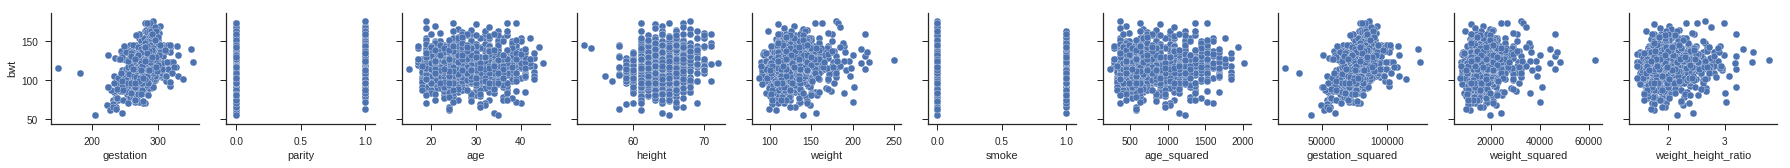

In [70]:
#I want to visually check for outliers in age, gestation, and weight
import seaborn as sns
Xlabels = bwt_df.columns.drop('bwt')
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=bwt_df, y_vars=['bwt'], x_vars=Xlabels)

In [28]:
#the 25th quantile is 108 oz, so lets decrease from there
qlist = [0.05, 0.1, 0.15, 0.2, 0.25]
for quantile in qlist:
  print(bwt_df['bwt'].quantile(quantile))

88.0
97.0
101.0
104.0
108.0


In [29]:
qlist = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for quantile in qlist:
  print(bwt_df['bwt'].quantile(quantile))

88.0
91.0
93.0
94.0
96.0
97.0


In [71]:
#lets' use 0.06
#MODEL 1 - 23.32%
import statsmodels.formula.api as smf
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2332
Model:                       QuantReg   Bandwidth:                       6.141
Method:                 Least Squares   Sparsity:                        109.4
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:08:44   Df Residuals:                     1163
                                        Df Model:                           10
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -90.4812    147.498     -0.613      0.540    -379.873     198.911
gestation               3.4651      0.579      5.982      0.000       2.329       4.602
parity                 -1.9938      2.007     -0.993      0.321      -5.932       1.944
age                     1.2437      1.160      1.072      0.284      -1.032       3.520
height                 -7.3481      2.001     -3.672      0.000     -11.274      -3.422
weight                  5.4626      1.057      5.166      0.000       3.388       7.537
smoke                  -8.6570      1.564     -5.534      0.000     -11.726      -5.588
age_squared            -0.0257      0.020     -1.311      0.190      -0.064       0.013
gestation_squared      -0.0053      0.001     -4.725      0.000      -0.008      -0.003
weight_squared         -0.0054      0.001     -6.359      0.000      -0.007      -0.004
weight_height_ratio  -257.4879     60.535     -4.254      0.000    -376.259    -138.717
=======================================================================================

The condition number is large, 1.87e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
PValueClub = ['bwt','gestation', 'height', 'weight', 'smoke', 'gestation_squared',
              'weight_squared', 'weight_height_ratio']
newdf = bwt_df[PValueClub]

In [76]:
#MODEL 2 - 22.88%
#Changes: Included only features with a <0.05 P
quant_formula = 'bwt ~ ' + ' + '.join(newdf.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=newdf)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()

bwt ~ gestation + height + weight + smoke + gestation_squared + weight_squared + weight_height_ratio


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2288
Model:                       QuantReg   Bandwidth:                       6.085
Method:                 Least Squares   Sparsity:                        117.1
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:11:07   Df Residuals:                     1166
                                        Df Model:                            7
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -116.1735    154.502     -0.752      0.452    -419.307     186.960
gestation               3.3757      0.541      6.241      0.000       2.314       4.437
height                 -6.2413      2.122     -2.941      0.003     -10.405      -2.078
weight                  4.8046      1.092      4.400      0.000       2.662       6.947
smoke                  -9.0817      1.688     -5.379      0.000     -12.394      -5.769
gestation_squared      -0.0052      0.001     -4.982      0.000      -0.007      -0.003
weight_squared         -0.0048      0.001     -4.779      0.000      -0.007      -0.003
weight_height_ratio  -227.7990     62.491     -3.645      0.000    -350.406    -105.192
=======================================================================================

The condition number is large, 1.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
#MODEL 3 - 21.3%
#Changes: included a weight height ratio squared
#to try to resolve 'significant' but ridiculous coef
newdf['ratio_squared'] = newdf['weight_height_ratio'] ** 2
quant_formula = 'bwt ~ ' + ' + '.join(newdf.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=newdf)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()
#yeah there's the sauce
#more sensible coefficents for ratio but also lowers r2
#and increases p value of ratio alone

bwt ~ gestation + height + weight + smoke + gestation_squared + weight_squared + weight_height_ratio + ratio_squared


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2130
Model:                       QuantReg   Bandwidth:                       6.313
Method:                 Least Squares   Sparsity:                        114.0
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:14:15   Df Residuals:                     1165
                                        Df Model:                            8
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.3705     57.418     -0.111      0.912    -119.025     106.284
gestation               1.7409      0.783      2.224      0.026       0.205       3.276
height                 -4.6794      1.049     -4.461      0.000      -6.737      -2.622
weight                  1.7281      1.021      1.692      0.091      -0.276       3.732
smoke                  -8.7034      1.643     -5.297      0.000     -11.927      -5.479
gestation_squared      -0.0023      0.001     -1.584      0.113      -0.005       0.001
weight_squared          0.0038      0.003      1.346      0.179      -0.002       0.009
weight_height_ratio   -11.5432     63.152     -0.183      0.855    -135.448     112.362
ratio_squared         -40.0512     11.775     -3.401      0.001     -63.153     -16.949
=======================================================================================

The condition number is large, 7.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
#MODEL 4 - absolute shit
#Changes: removed gestation features after they failed P above
#gestation is critical to the regression working
PValueClub = ['bwt','gestation', 'height', 'weight', 'smoke', 'gestation_squared',
              'weight_squared', 'weight_height_ratio']
newdf = bwt_df[PValueClub]
newdf['ratio_squared'] = newdf['weight_height_ratio'] ** 2
newdf = newdf.drop(columns=['gestation',
                            'gestation_squared'])

quant_formula = 'bwt ~ ' + ' + '.join(newdf.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=newdf)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


bwt ~ height + weight + smoke + weight_squared + weight_height_ratio + ratio_squared


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:              0.04907
Model:                       QuantReg   Bandwidth:                       6.788
Method:                 Least Squares   Sparsity:                        164.1
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:22:33   Df Residuals:                     1167
                                        Df Model:                            6
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              36.0862    623.355      0.058      0.954   -1186.935    1259.108
height                  0.3725      9.719      0.038      0.969     -18.696      19.441
weight                  0.0174      8.484      0.002      0.998     -16.628      16.662
smoke                 -11.8987      2.362     -5.037      0.000     -16.534      -7.264
weight_squared      -7.427e-05      0.014     -0.005      0.996      -0.028       0.028
weight_height_ratio    39.5254    545.711      0.072      0.942   -1031.160    1110.210
ratio_squared         -10.4876     59.974     -0.175      0.861    -128.157     107.182
=======================================================================================

The condition number is large, 1.69e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
#MODEL 5 - 20.54%
#Changes: removed height as it only seems predictive insofar as its ratio
#restored gest

PValueClub = ['bwt','gestation', 'height', 'weight', 'smoke', 'gestation_squared',
              'weight_squared', 'weight_height_ratio']
newdf = bwt_df[PValueClub]
newdf['ratio_squared'] = newdf['weight_height_ratio'] ** 2
newdf = newdf.drop(columns=['height'])

quant_formula = 'bwt ~ ' + ' + '.join(newdf.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=newdf)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()

#makes weight poly act strangely and increases the p values on everything

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


bwt ~ gestation + weight + smoke + gestation_squared + weight_squared + weight_height_ratio + ratio_squared


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2054
Model:                       QuantReg   Bandwidth:                       6.314
Method:                 Least Squares   Sparsity:                        108.6
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:30:44   Df Residuals:                     1166
                                        Df Model:                            7
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -115.9561    130.207     -0.891      0.373    -371.422     139.510
gestation               0.9016      0.941      0.958      0.338      -0.946       2.749
weight                  0.5955      0.831      0.717      0.474      -1.034       2.225
smoke                  -9.6620      1.637     -5.901      0.000     -12.874      -6.450
gestation_squared      -0.0009      0.002     -0.507      0.613      -0.004       0.003
weight_squared         -0.0005      0.003     -0.190      0.850      -0.006       0.005
weight_height_ratio     0.9336     57.168      0.016      0.987    -111.230     113.097
ratio_squared          -8.6678     12.334     -0.703      0.482     -32.868      15.532
=======================================================================================

The condition number is large, 8.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
#LAST MODEL - 22.61%
#Changes: did the opposite to 5 and added height^2
#if it has a relationship it is probably not linear
#Result: one of the better scores, bad p values
#makes height look a lot more relevant; is probably inaccurate

PValueClub = ['bwt','gestation', 'height', 'weight', 'smoke', 'gestation_squared',
              'weight_squared', 'weight_height_ratio']
newdf = bwt_df[PValueClub]
newdf['ratio_squared'] = newdf['weight_height_ratio'] ** 2
newdf['height_squared'] = newdf['height'] ** 2

quant_formula = 'bwt ~ ' + ' + '.join(newdf.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=newdf)
quant_reg = quant_mod.fit(q=.06)
quant_reg.summary()

bwt ~ gestation + height + weight + smoke + gestation_squared + weight_squared + weight_height_ratio + ratio_squared + height_squared


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2261
Model:                       QuantReg   Bandwidth:                       6.097
Method:                 Least Squares   Sparsity:                        122.6
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        01:39:14   Df Residuals:                     1164
                                        Df Model:                            9
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.5519    111.647     -0.005      0.996    -219.604     218.500
gestation               3.5870      0.561      6.394      0.000       2.486       4.688
height                -15.3635      6.650     -2.310      0.021     -28.411      -2.316
weight                  0.9855      2.775      0.355      0.723      -4.459       6.430
smoke                  -9.6719      1.784     -5.420      0.000     -13.173      -6.171
gestation_squared      -0.0056      0.001     -5.180      0.000      -0.008      -0.003
weight_squared         -0.0004      0.005     -0.075      0.940      -0.011       0.010
weight_height_ratio    -1.8033    178.973     -0.010      0.992    -352.949     349.342
ratio_squared         -13.7754     22.129     -0.623      0.534     -57.192      29.641
height_squared          0.1124      0.076      1.481      0.139      -0.036       0.261
=======================================================================================

The condition number is large, 1.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 I am basing these observations on **Model 2**, for having the best combination of r2 and feature P values.
 
**What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?**

I found the largest coefficients in the negative direction to be whether a mother smoked while gestating (meaning values above the 0.06 percentile, babies above 91 ounces, strongly trended to 0 on that binary rather than 1) and the mothers' weight over height ratio (meaning babies strongly trended to lower ratios). We can be less certain about the weight ratio relationship than smoking because its p value would jump around when you add and remove features, and its overwhelmingly high coefficient compared to any other variable indicates something MUST be up but the accuracy's partially comprimised.

**What can expectant mothers be told to help mitigate this risk?**

If you smoke you are far more likely to carry a child below 90 ounces who is then far more likely to have health complications. This combined with the known genetic damage caused by smoking makes me strongly advise being on a hormonal birth control in periods of life while you are smoking, and getting counseling to stop when you decide you want children. It's believed you having a large weight to height, as well, puts children at risk. Please don't worry about having a higher risk with age should you need to take time to lose weight or recover from addiction. There was nothing in our analysis to prove this relationship was more than chance while smoking, no matter what I did to the dataset, was always a strongly negative test statistic at a very low P value.

In [100]:
PValueClub = ['bwt','gestation', 'height', 'weight', 'smoke', 'gestation_squared',
              'weight_squared', 'weight_height_ratio']
newdf = bwt_df[PValueClub]
print('The Coorelation of Birth Weight to Features:')
print('Smoking is the only feature unambiguously anticorrelated.')
print('We can imagine weight and weight ratio being a U curve where a too low weight')
print('is bad, too, so the relationship is muddled a bit in simple coorelation.')
corr = newdf.corr()
corr.head(1)

The Coorelation of Birth Weight to Features:
Smoking is the only feature unambiguously anticorrelated.
We can imagine weight and weight ratio being a U curve where a too low weight
is bad, too, so the relationship is muddled a bit in simple coorelation.


,bwt,gestation,height,weight,smoke,gestation_squared,weight_squared,weight_height_ratio
bwt,1.0,0.407543,0.203704,0.155923,-0.2468,0.403542,0.143954,0.115705


In [105]:
newdf = bwt_df[PValueClub]
newdf = newdf[newdf.bwt > 91]
print('The Same Corr Table Only For Weights Above 91 oz')
print('Gestation becomes less relevant as height, weight and their ratio increases relevance')
corr = newdf.corr()
corr.head(1)

The Same Corr Table Only For Weights Above 91 oz
Gestation becomes less relevant as height, weight and their ratio increases relevance


,bwt,gestation,height,weight,smoke,gestation_squared,weight_squared,weight_height_ratio
bwt,1.0,0.278384,0.216623,0.191024,-0.225583,0.277956,0.180229,0.150055


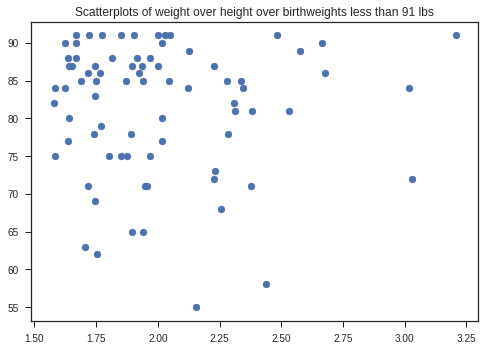

In [108]:
import matplotlib.pyplot as plt
newdf = bwt_df[PValueClub]
newdf = newdf[newdf.bwt <= 91]
plt.scatter(newdf['weight_height_ratio'], newdf['bwt'])
plt.title('Scatterplots of weight over height over birthweights less than 91 lbs')
plt.show()

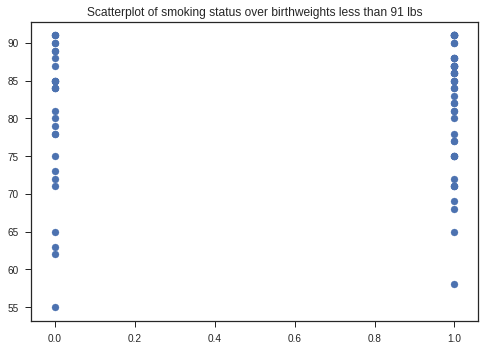

In [111]:
newdf = bwt_df[PValueClub]
newdf = newdf[newdf.bwt <= 91]
plt.scatter(newdf['smoke'], newdf['bwt'])
plt.title('Scatterplot of smoking status over birthweights less than 91 lbs')
plt.show()

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model